In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [8]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [5]:
conv = nn.Conv2d(3, 16, kernel_size=5)
conv

Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))

In [6]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 5, 5]), torch.Size([16]))

In [9]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 28, 28]))

In [13]:
conv = nn.Conv2d(3, 1, kernel_size=5, padding=2)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [14]:
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

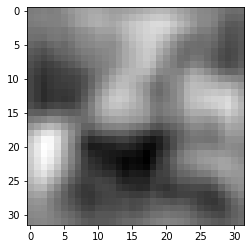

In [15]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [16]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

# 커널을 직접 바꾸기
# 가로로 인접한 두 영역 사이의 수직 경계를 탐색하는 역할

In [17]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [18]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=5, padding=2),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... 중요한게 하나 빠져있음
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [19]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list
# 총 파라미터 수 세기

(20906, [1200, 16, 3200, 8, 16384, 32, 64, 2])

- 파라미터 수 증가

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, padding=2)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # 앞에서 놓쳤던 차원 정보 변경
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [21]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(20906, [1200, 16, 3200, 8, 16384, 32, 64, 2])

In [22]:
# 함수형 API 이용한 Net 간결 버전 코드
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [23]:
model = Net()
model(img.unsqueeze(0))

tensor([[ 0.1232, -0.1478]], grad_fn=<AddmmBackward0>)

In [24]:
import datetime  # 파이썬에 포함된 datetime 모듈 사용

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1): 
        loss_train = 0.0
        for imgs, labels in train_loader:  # 데이터 로더가 만들어준 배치 안에서 데이터셋을 순회함
            
            outputs = model(imgs)  # 모델에 배치 넣어줌
            
            loss = loss_fn(outputs, labels)  # 최소화하려는 손실값 계산

            optimizer.zero_grad()  # 마지막에 이전 기울기 값 지움
            
            loss.backward()  # 역전파 수행, 신경망이 학습할 모든 파라미터에 대한 기울기를 계산
            
            optimizer.step()  # 모델 업데이트

            loss_train += loss.item()  
            # 에포크동안 확인한 손실값 모두 더함. 기울기값을 꺼내고자 .item() 사용해 손실값으로 파이썬 수로 변환 시킴

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # 배치 단위의 평균 손실값 구하기 위해 훈련 데이터 로더의 길이로 나눔

In [25]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-09-12 17:33:44.531487 Epoch 1, Training loss 0.5596596547372782
2022-09-12 17:34:21.444900 Epoch 10, Training loss 0.31791146365320605
2022-09-12 17:35:04.091014 Epoch 20, Training loss 0.28216634254167033
2022-09-12 17:35:52.692469 Epoch 30, Training loss 0.25078650108378403
2022-09-12 17:36:40.776571 Epoch 40, Training loss 0.22250529919650144
2022-09-12 17:37:30.199122 Epoch 50, Training loss 0.19829885984302326
2022-09-12 17:38:20.534719 Epoch 60, Training loss 0.17688316301365567
2022-09-12 17:39:14.228640 Epoch 70, Training loss 0.1551471356848243
2022-09-12 17:40:03.388869 Epoch 80, Training loss 0.13819130642968377
2022-09-12 17:40:50.493775 Epoch 90, Training loss 0.118316128992351
2022-09-12 17:41:45.360974 Epoch 100, Training loss 0.10272454501242395


In [26]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # 파라미터 업데이트하지 않을 것이므로 기울기는 필요 없음
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # 가장 높은 값을 가진 인덱스 출력
                total += labels.shape[0]  # 예제 수를 세어서 total을 배치 크기만큼 증가시킴
                correct += int((predicted == labels).sum())  # 

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.96
Accuracy val: 0.89


- 더욱 과적합이 됨

- kernel_size = (1,3)

https://stackoverflow.com/questions/59946176/non-squared-convolution-kernel-size

https://stats.stackexchange.com/questions/351115/convolution-with-a-non-square-kernel

https://towardsdatascience.com/types-of-convolution-kernels-simplified-f040cb307c37
